In [1]:
%matplotlib inline

import pathlib
import urllib.request

import matplotlib.pyplot as plt
import pandas as pd

LMASK = 'https://ldas.gsfc.nasa.gov/gldas/data/0.25deg/landmask_mod44w_025.asc'

LMASK_CSV = pathlib.Path(LMASK.rpartition('/')[2])

LMASK_FORMAT = {'names': ['col', 'row', 'latitude', 'longitude', 'land'],
                'index_col': ['col', 'row'],
                'dtype': {'land': bool},
                'header': None,
                'delim_whitespace': True,
                'encoding': 'ascii'}

if not LMASK_CSV.exists():
    urllib.request.urlretrieve(LMASK, LMASK_CSV)

lm = pd.read_csv(LMASK_CSV, **LMASK_FORMAT)

lm.info()
assert lm.index.is_unique

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 864000 entries, (1, 1) to (1440, 600)
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   864000 non-null  float64
 1   longitude  864000 non-null  float64
 2   land       864000 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 17.4 MB


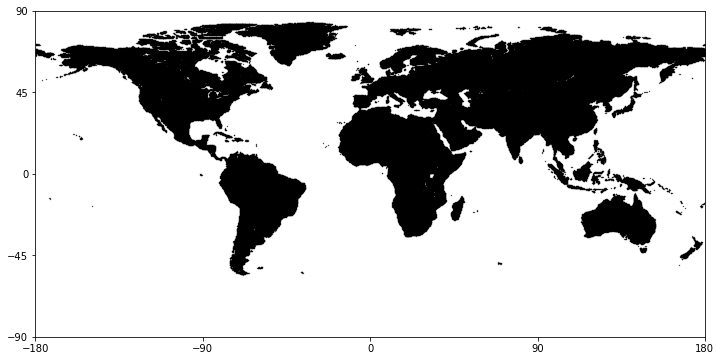

In [2]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axis([-180, 180, -90, 90])
ax.set_xticks(range(-180, 181, 90))
ax.set_yticks(range(-90, 91, 45))

ax.scatter('longitude', 'latitude', .1, color='k', data=lm[lm['land']]);

In [3]:
FACTOR = 16

lm['lat'] = pd.cut(lm['latitude'], lm['latitude'].nunique() // FACTOR)
lm['lon'] = pd.cut(lm['longitude'], lm['longitude'].nunique() // FACTOR)

lmx = (lm.groupby(['lat', 'lon'])
       .agg({'latitude': 'min', 'longitude': 'min', 'land': 'any'})
       .reset_index(drop=True))

lmx.head()

,latitude,longitude,land
0,-59.875,-179.875,False
1,-59.875,-175.875,False
2,-59.875,-171.875,False
3,-59.875,-167.875,False
4,-59.875,-163.875,False


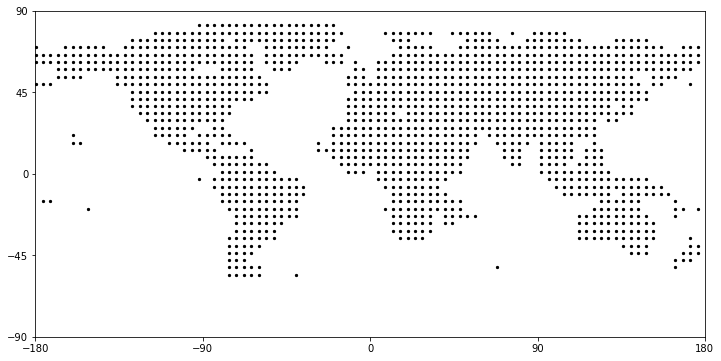

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axis([-180, 180, -90, 90])
ax.set_xticks(range(-180, 181, 90))
ax.set_yticks(range(-90, 91, 45))

ax.scatter('longitude', 'latitude', 5, color='k', data=lmx[lmx['land']]);

In [5]:
import sqlalchemy as sa

engine = sa.create_engine('postgresql://postgres@/glottolog3')

query = '''SELECT l.id, l.name, l.latitude, l.longitude, macroarea, ll.level
FROM language AS l
JOIN languoid AS ll USING (pk),
regexp_split_to_table(ll.macroareas, ', ') AS macroarea
WHERE l.latitude IS NOT NULL ORDER BY id'''

df = pd.read_sql_query(query, engine, index_col='id')

df.info()
assert df.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 8437 entries, aari1239 to zyph1238
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       8437 non-null   object 
 1   latitude   8437 non-null   float64
 2   longitude  8437 non-null   float64
 3   macroarea  8437 non-null   object 
 4   level      8437 non-null   object 
dtypes: float64(2), object(3)
memory usage: 395.5+ KB


In [6]:
x = df[['latitude', 'longitude']].reset_index()

lats = lmx['latitude'].unique()
lons = lmx['longitude'].unique()

x['latitude'] = pd.cut(x['latitude'], lats, labels=lats[:-1]).astype(float)
x['longitude'] = pd.cut(x['longitude'], lons, labels=lons[:-1]).astype(float)

x = x.merge(lmx, how='left', on=['latitude', 'longitude']).set_index('id')

x.head()

,latitude,longitude,land
id,,,
aari1239,5.125,36.125,True
aasa1238,-7.125,36.125,True
abad1241,-11.125,144.125,True
abag1245,-7.125,144.125,True
abai1240,5.125,116.125,True


In [7]:
df['land'] = x['land'].fillna(True)

df['land'].value_counts().to_frame().T

,True,False
land,8346,91


In [8]:
df.loc[~df['land'], 'macroarea'].value_counts().to_frame('water').T

,Papunesia,Eurasia,North America,Africa
water,70,16,4,1


In [9]:
df.query('~land & macroarea == "Eurasia"')

,name,latitude,longitude,macroarea,level,land
id,,,,,,
amam1247,Amami O Shima Sign Language,28.268372,129.358991,Eurasia,language,False
cent2126,Central Okinawan,26.148540,127.781600,Eurasia,language,False
chuv1256,Chuvantsy,57.520000,175.610000,Eurasia,language,False
dhiv1236,Dhivehi,1.928498,73.544330,Eurasia,language,False
hach1239,Hachijo,33.109444,139.791389,Eurasia,language,False
irab1238,Irabu-Jima,24.831088,125.189560,Eurasia,dialect,False
kika1239,Kikai,28.310000,129.982000,Eurasia,language,False
kuni1268,Kunigami,26.591100,128.068000,Eurasia,language,False
kuri1271,Kuril Ainu,49.401648,154.722412,Eurasia,language,False


In [10]:
df.query('~land & macroarea in ("Africa", "North America")')

,name,latitude,longitude,macroarea,level,land
id,,,,,,
baja1265,Bajan,13.136500,-59.534600,North America,language,False
oldc1248,Old Cayman Sign Language,19.333333,-81.216667,North America,language,False
sese1246,Seselwa Creole French,-4.623140,55.450300,Africa,language,False
turk1310,Turks And Caicos Creole English,21.807800,-71.745100,North America,language,False
virg1240,Virgin Islands Creole English,18.047150,-63.078510,North America,language,False


In [11]:
df.query('~land & macroarea == "Papunesia"')

,name,latitude,longitude,macroarea,level,land
id,,,,,,
anei1239,Aneityum,-20.186400,169.825000,Papunesia,language,False
anut1237,Anuta,-11.610000,169.850000,Papunesia,language,False
aust1304,Austral,-23.384300,-149.462000,Papunesia,language,False
ayiw1239,Äiwoo,-10.282595,166.328715,Papunesia,language,False
caro1242,Carolinian,15.205000,145.765000,Papunesia,language,False
...,...,...,...,...,...,...
wall1257,East Uvean,-13.290300,-176.207000,Papunesia,language,False
whit1269,Whitesands,-19.501900,169.381000,Papunesia,language,False
wole1240,Woleaian,7.379570,143.916000,Papunesia,language,False
